In [67]:
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import RandomResizedCrop,Normalize,ToTensor,Compose
import evaluate
import torch
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import os

In [18]:
dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

In [19]:
dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 12600
})

In [20]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x160>,
 'labels': 11}

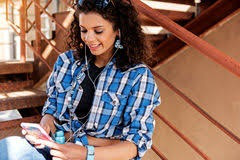

In [21]:
dataset[0]['image']

In [22]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

In [23]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop'], id=None)}

In [24]:
labels = dataset['train'].features['labels'].names
labels

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [25]:
label2id = {}
id2label = {}
for i,label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
print(label2id)
print(id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


In [26]:
model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt,use_fast = True)

In [27]:
normalize = Normalize(image_processor.image_mean,image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size
        else (image_processor.size['height'],image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size),ToTensor(),normalize])

def transform(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]  # convert method for PIL image
    del batch['image']
    return batch

dataset = dataset.with_transform(transform)

In [28]:
accuracy = evaluate.load('accuracy')

def comput_metrics(pred_eval):
    predictions_logits, labels = pred_eval
    predictions = np.argmax(predictions_logits,axis=1)
    return accuracy.compute(predictions=predictions,references=labels)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForImageClassification.from_pretrained(model_ckpt,num_labels=len(label2id),label2id=label2id,id2label=id2label).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
args = TrainingArguments(
    output_dir='train_dir',
    remove_unused_columns=False,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

In [31]:
trainer = Trainer(
    model=model,
    args=args,
    processing_class = image_processor, #tokenizer` is deprecated 
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=comput_metrics
)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.066200,1.389705,0.735317
2,1.336900,1.109403,0.762302
3,1.108200,1.074315,0.753968


TrainOutput(global_step=1890, training_loss=1.4051866157975776, metrics={'train_runtime': 1129.3772, 'train_samples_per_second': 26.776, 'train_steps_per_second': 1.673, 'total_flos': 2.343630802013061e+18, 'train_loss': 1.4051866157975776, 'epoch': 3.0})

In [33]:
trainer.evaluate()

{'eval_loss': 1.1357545852661133,
 'eval_accuracy': 0.7468253968253968,
 'eval_runtime': 26.6459,
 'eval_samples_per_second': 94.574,
 'eval_steps_per_second': 5.93,
 'epoch': 3.0}

In [68]:
trainer.save_model('vit-human-pose-classification')

In [ ]:
logits = trainer.predict(dataset['test'])

In [44]:
type(logits.predictions)

numpy.ndarray

In [47]:
y_pred = np.argmax(logits.predictions,axis=1)

In [51]:
y_true = np.array([ x['labels'] for x in dataset['test']])

In [53]:
print(classification_report(y_true,y_pred,target_names=labels))

                    precision    recall  f1-score   support

           calling       0.62      0.70      0.66       173
          clapping       0.78      0.78      0.78       164
           cycling       0.97      0.91      0.94       175
           dancing       0.85      0.77      0.81       171
          drinking       0.74      0.81      0.77       154
            eating       0.85      0.80      0.82       182
          fighting       0.81      0.83      0.82       175
           hugging       0.74      0.82      0.78       165
          laughing       0.77      0.68      0.72       161
listening_to_music       0.76      0.67      0.71       156
           running       0.76      0.77      0.77       172
           sitting       0.60      0.62      0.61       156
          sleeping       0.79      0.85      0.82       170
           texting       0.69      0.58      0.63       177
      using_laptop       0.68      0.74      0.71       169

          accuracy                    

In [56]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[121,   4,   0,   1,   2,   2,   1,   2,   4,  11,   2,   3,   4,
          9,   7],
       [  4, 128,   0,   2,   1,   4,   3,   0,   8,   0,   1,   8,   0,
          3,   2],
       [  0,   0, 160,   1,   1,   0,   1,   0,   0,   0,   8,   2,   0,
          1,   1],
       [  2,   7,   0, 131,   0,   0,   7,   4,   2,   2,  11,   4,   0,
          0,   1],
       [  5,   1,   0,   2, 125,   3,   0,   3,   2,   5,   0,   1,   2,
          5,   0],
       [  2,   2,   0,   0,   9, 145,   1,   2,   2,   0,   0,   6,   2,
          3,   8],
       [  0,   3,   0,   6,   0,   1, 146,   4,   0,   0,   7,   3,   3,
          1,   1],
       [  5,   2,   0,   1,   1,   0,   0, 136,   3,   0,   1,   3,   6,
          4,   3],
       [  6,   7,   0,   0,  11,   1,   0,  10, 109,   3,   0,   4,   7,
          2,   1],
       [ 13,   1,   0,   0,   7,   2,   0,   2,   3, 105,   3,   8,   4,
          7,   1],
       [  0,   2,   3,   7,   0,   0,  18,   2,   0,   1, 133,   4,   1,
       

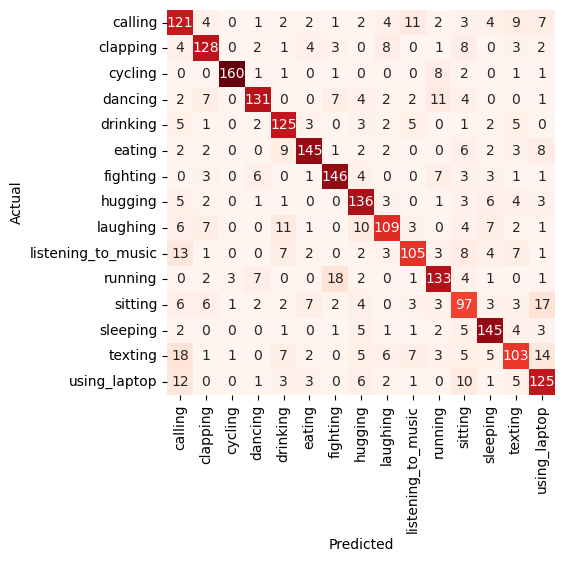

In [65]:
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d',cbar=False,cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [70]:
classifer = pipeline(
    task='image-classification',
    model='vit-human-pose-classification',
    image_processor=image_processor)

Device set to use cuda:0


In [71]:
url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

output = classifer(url)
output

[{'label': 'sitting', 'score': 0.3587130010128021},
 {'label': 'using_laptop', 'score': 0.084348164498806},
 {'label': 'running', 'score': 0.08109431713819504},
 {'label': 'sleeping', 'score': 0.06513471156358719},
 {'label': 'texting', 'score': 0.06252080947160721}]

In [73]:
s3 = boto3.client('s3')
BUCKET_NAME = "mlops-kgptalkie-faraz"

In [74]:
def upload_directory(directory,s3_prefix):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root,file)
            rel_path = os.path.relpath(file_path,directory)
            s3_key = os.path.join(s3_prefix,rel_path).replace("\\","/")

            s3.upload_file(file_path,BUCKET_NAME,s3_key)

In [76]:
upload_directory('vit-human-pose-classification','ml-models/vit-human-pose-classification')